In [46]:
!pip install monai -q

In [47]:
import numpy as np
import pandas as pd
from pathlib import Path
import monai.transforms as MT
from monai.visualize import matshow3d, blend_images
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

In [48]:
im = Path('/kaggle/input/msd-lung-tumours/Task06_Lung/imagesTr')
im = sorted(list(im.glob('*.nii')))
lb = Path('/kaggle/input/msd-lung-tumours/Task06_Lung/labelsTr')
lb = sorted(list(lb.glob('*.nii')))

samples = [{'image':m,'label':l} for m,l in zip(im,lb)]

In [49]:
train_tfms = MT.Compose([
    MT.LoadImaged(keys=['image','label']),
    MT.EnsureChannelFirstd(keys=['image','label']),
    MT.Orientationd(keys=["image", "label"], axcodes="RAS"),
    MT.Spacingd(keys=["image", "label"], 
                    pixdim=(1.5,1.5,2.0), 
                    mode=("bilinear", "nearest")
                ),
    MT.CropForegroundd(keys=["image", "label"], source_key="image",allow_smaller=True),
    MT.ScaleIntensityRanged(
        keys=['image'],
        a_min=-175.0,
        a_max=250.0,
        b_min=0.,
        b_max=1.,
        clip=True
    ),
    MT.RandZoomd(keys=['image','label'],min_zoom=0.9,max_zoom=1.5,mode=['area','nearest']),
    MT.RandCropByPosNegLabeld(
        keys=['image','label'],
        spatial_size=(96,96,96),
        pos=1,
        neg=1,
        image_key='image',
        label_key='label',
        num_samples=4,
        image_threshold=0
    ),
    MT.RandGibbsNoised(keys='image',alpha=(0.6,0.8)),
    MT.RandFlipd(keys=['image','label'],spatial_axis=[0],prob=0.1),
    MT.RandFlipd(keys=['image','label'],spatial_axis=[1],prob=0.1),
    MT.RandFlipd(keys=['image','label'],spatial_axis=[2],prob=0.1),
    MT.RandRotate90d(keys=['image','label'],prob=0.1,max_k=3),
    MT.GaussianSmoothd(keys='image',sigma=1.5),
    MT.RandScaleIntensityd(keys='image',factors=0.15),
    MT.RandShiftIntensityd(keys='image',offsets=0.15)
])


valid_tfms = MT.Compose([
    MT.LoadImaged(keys=['image','label']),
    MT.EnsureChannelFirstd(keys=['image','label']),
    MT.Orientationd(keys=["image", "label"], axcodes="RAS"),
    MT.Spacingd(keys=["image", "label"], 
                    pixdim=(1.,1.,1.), 
                    mode=("bilinear", "nearest")
                ),
    MT.CropForegroundd(keys=["image", "label"], source_key="image",allow_smaller=True),
    MT.ScaleIntensityRanged(
        keys=['image'],
        a_min=-175.0,
        a_max=250.0,
        b_min=0.,
        b_max=1.,
        clip=True
    )
])

In [50]:
def viz(sample,show_tumor_slices_only=True):
    im = sample['image']
    lb = sample['label']
    blend = blend_images(im,lb,rescale_arrays=False)
    if show_tumor_slices_only:
        slices_with_1 = list(set(torch.where(lb==1)[-1].numpy()))
        if len(slices_with_1) > 0:
            blend = blend[:,:,:,slices_with_1]
    matshow3d(blend,frame_dim=-1,channel_dim=0)
    plt.show()

torch.Size([1, 426, 383, 341])


/opt/conda/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


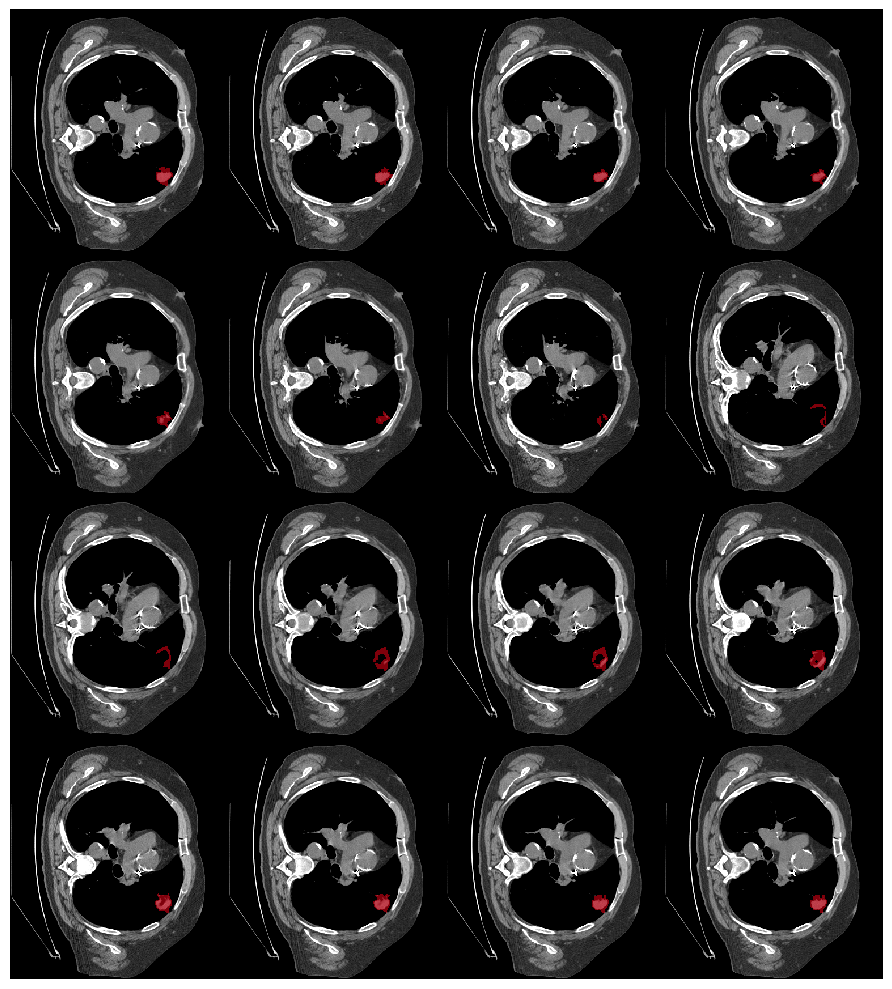

In [51]:
x = valid_tfms(samples[10])
print(x['image'].shape)
viz(x)

torch.Size([1, 419, 356, 299])


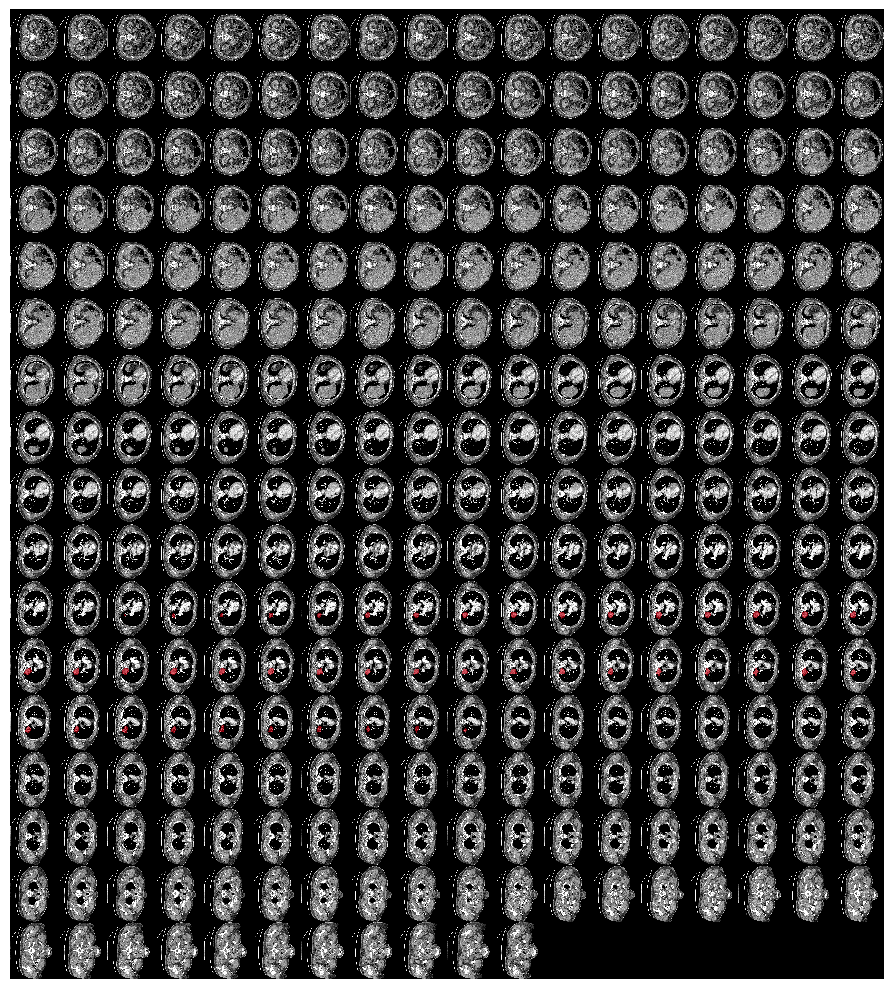

In [52]:
x = valid_tfms(samples[25])
print(x['image'].shape)
viz(x,False)

torch.Size([1, 96, 96, 96])


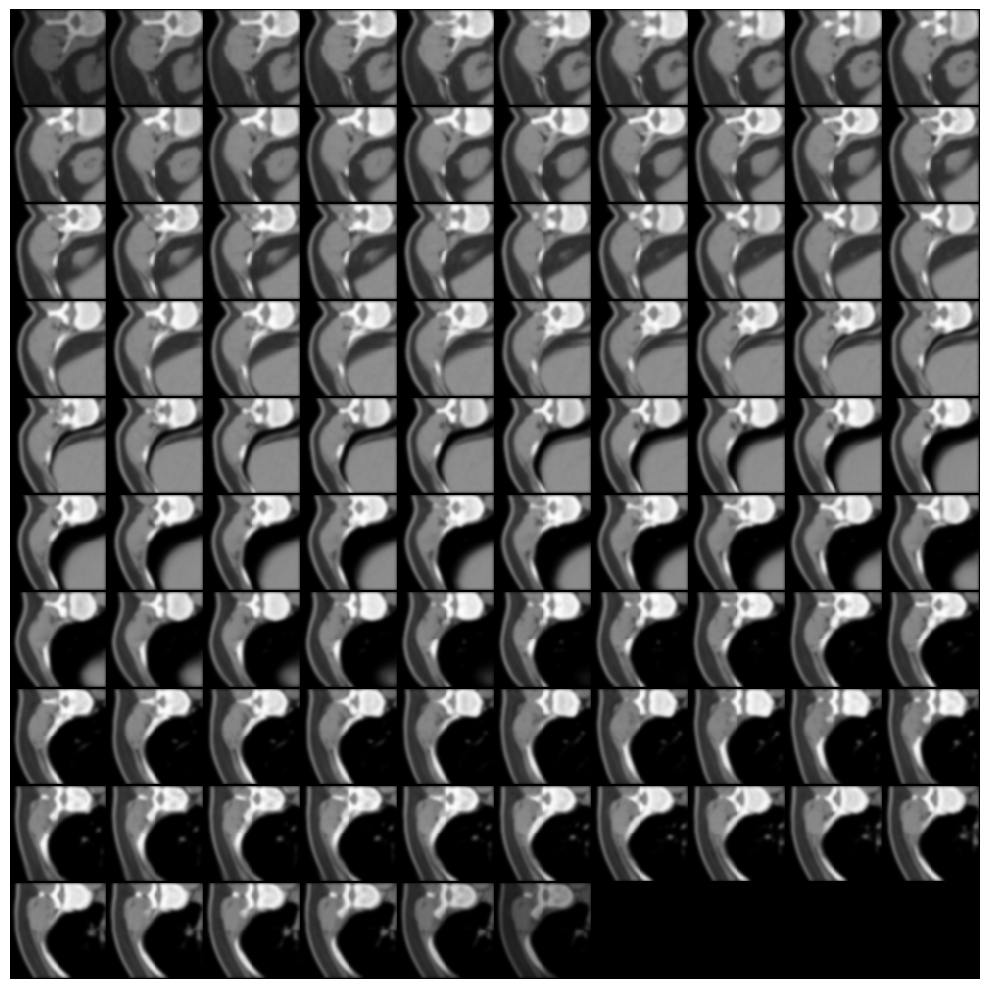

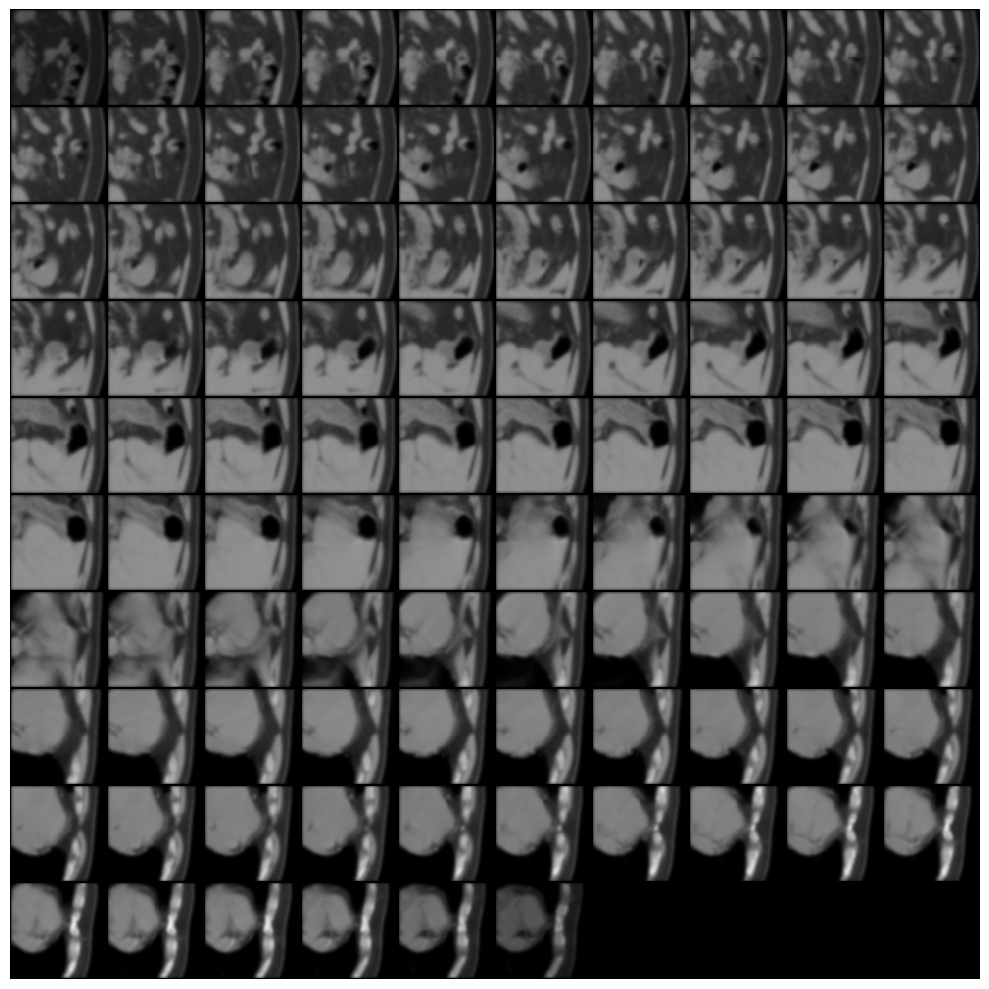

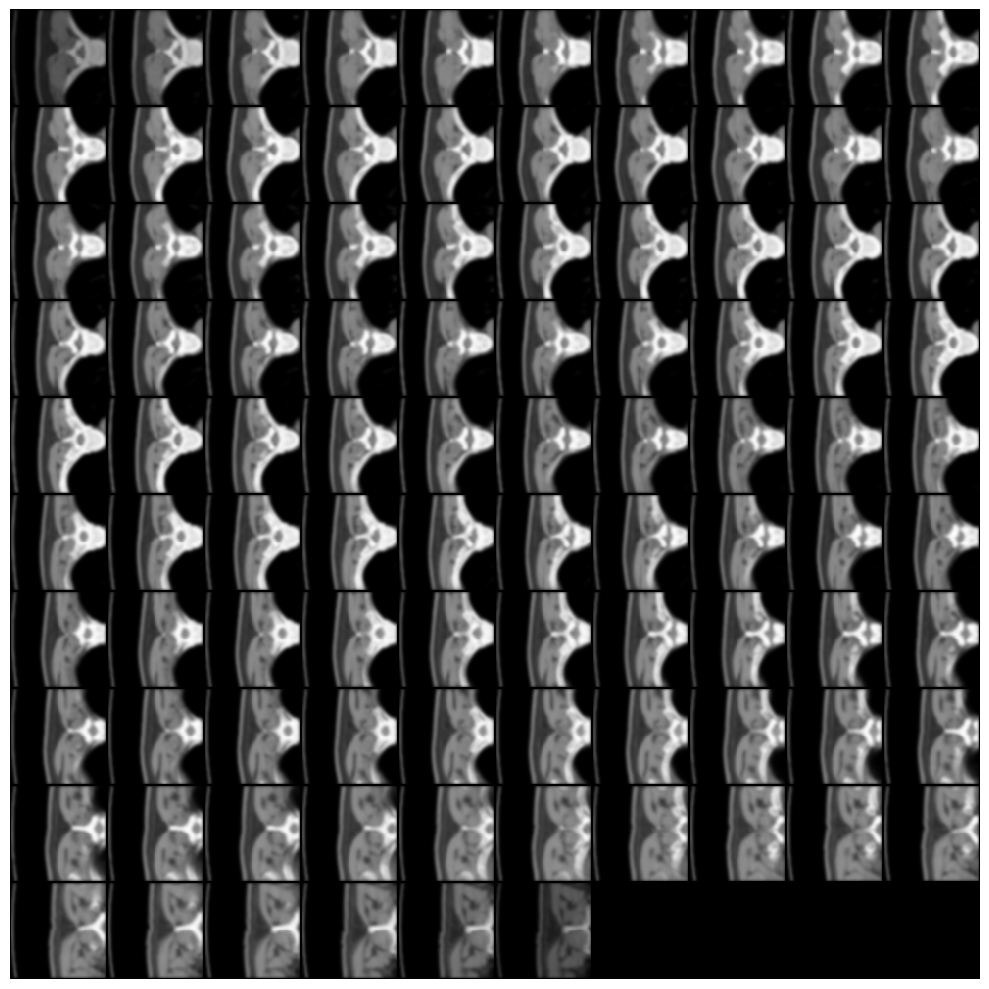

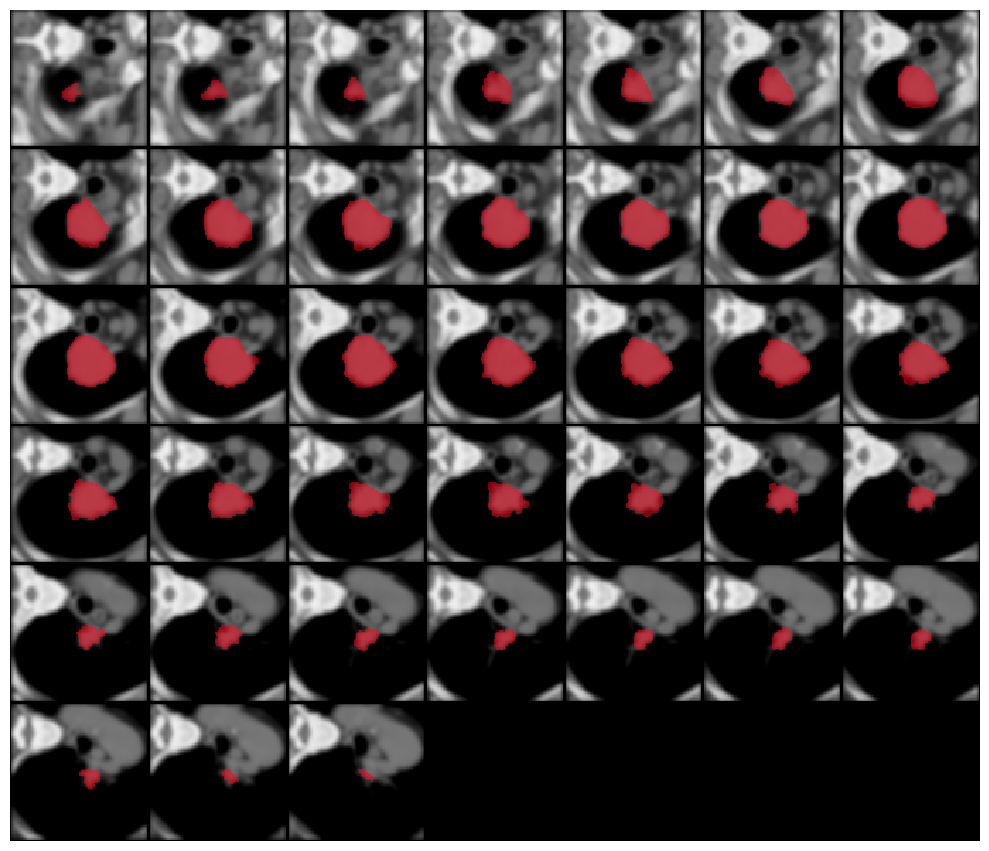

In [53]:
x = train_tfms(samples[5])
print(x[0]['image'].shape)
for c in x:
    viz(c)
    print()